In [8]:
import gzip, os, pickle

import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_model_optimization as tfmot
import ipywidgets as ipyw

from pathlib import Path
from tensorflow.keras import layers, optimizers, metrics, losses, models
from tensorflow.keras import applications as apps, callbacks as cbs
from tensorflow.keras.utils import plot_model, array_to_img
from matplotlib import pyplot as plt

In [9]:
! pip install -q git+https://github.com/EfficientDL/codelab_utils.git

import matplotlib.pyplot as plt
import codelab_utils.mpl_styles as mpl_styles

mpl_styles.set_default_styles()
plt.rcParams['font.family'] = 'Poppins'

In [10]:
(train_ds, val_ds, test_ds), ds_info = tfds.load(
    'oxford_iiit_pet',
    with_info=True,
    split=['train[:80%]', 'train[80%:]', 'test'],
    read_config=tfds.ReadConfig(try_autocache=False)
)

In [11]:
# Dataset image size
IMG_SIZE = 128

def normalize(image, mask):
    image = tf.cast(image, tf.float32) / 255.0
    mask -= 1
    
    return image, mask

def preprocess(item):
    image, mask = item['image'], item['segmentation_mask']
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
    mask = tf.image.resize(mask, [IMG_SIZE, IMG_SIZE])
    image, mask = normalize(image, mask)
    
    return image, mask

train_prep_ds = train_ds.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
val_prep_ds = val_ds.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
test_prep_ds = test_ds.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)

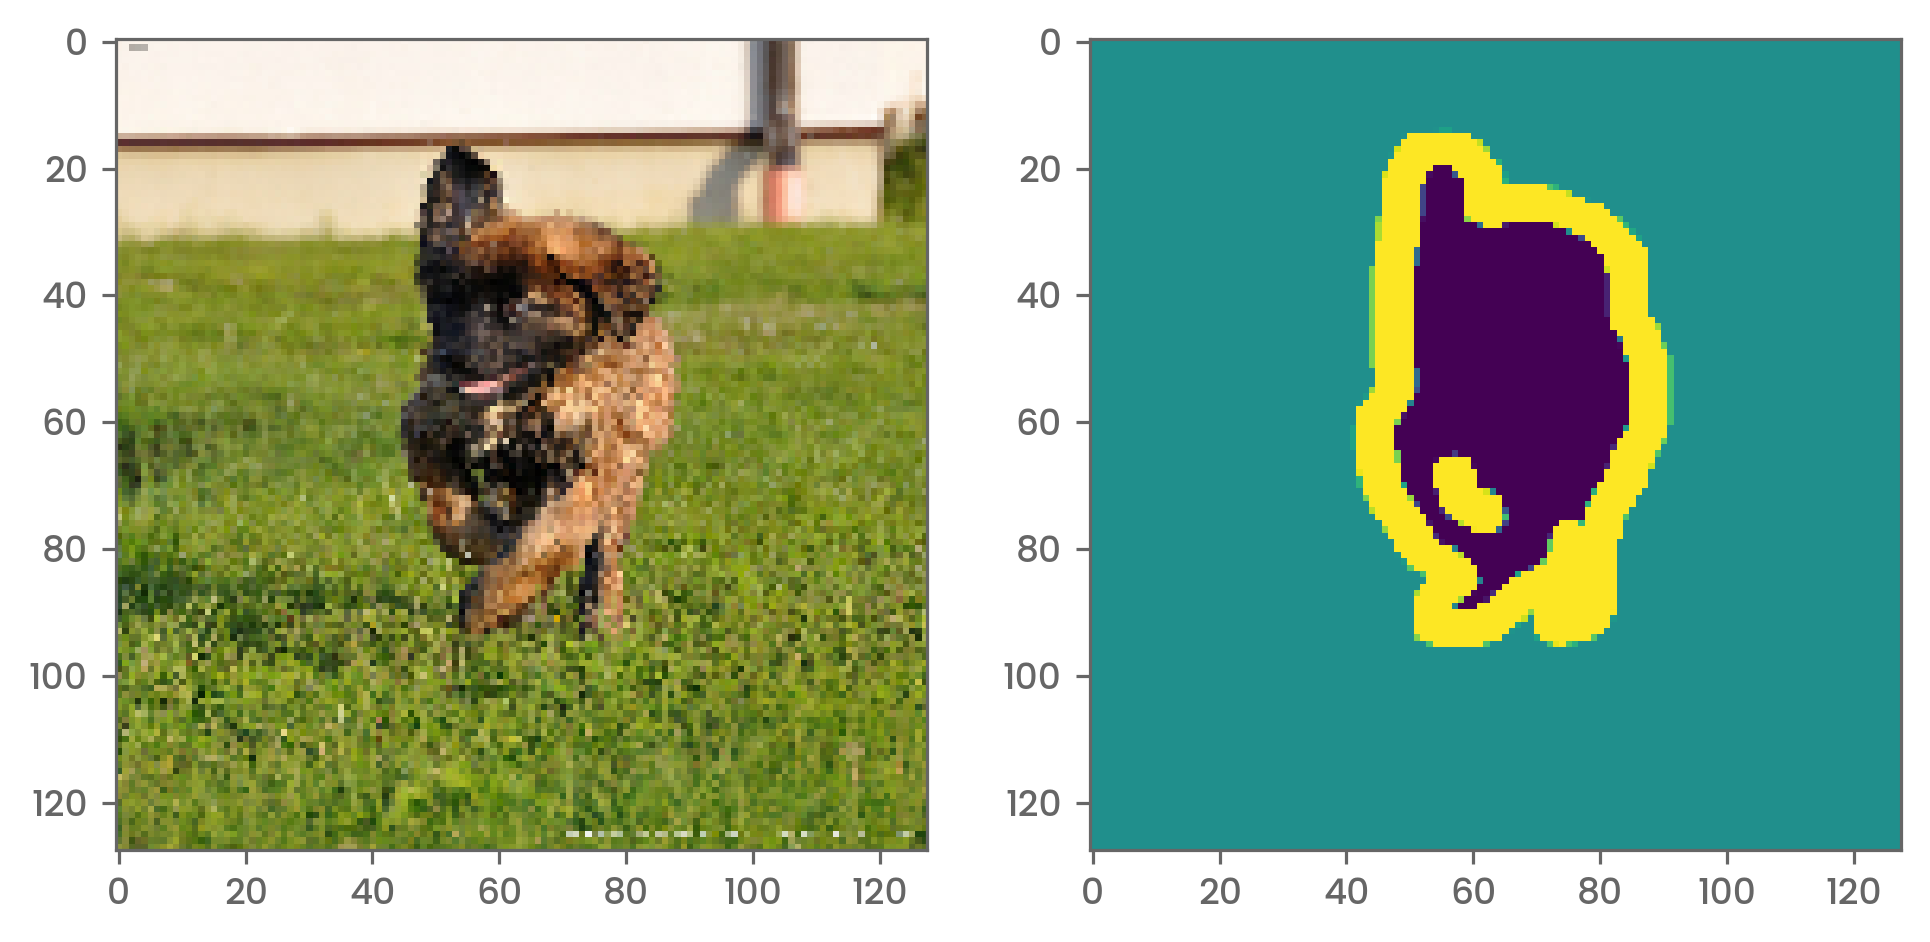

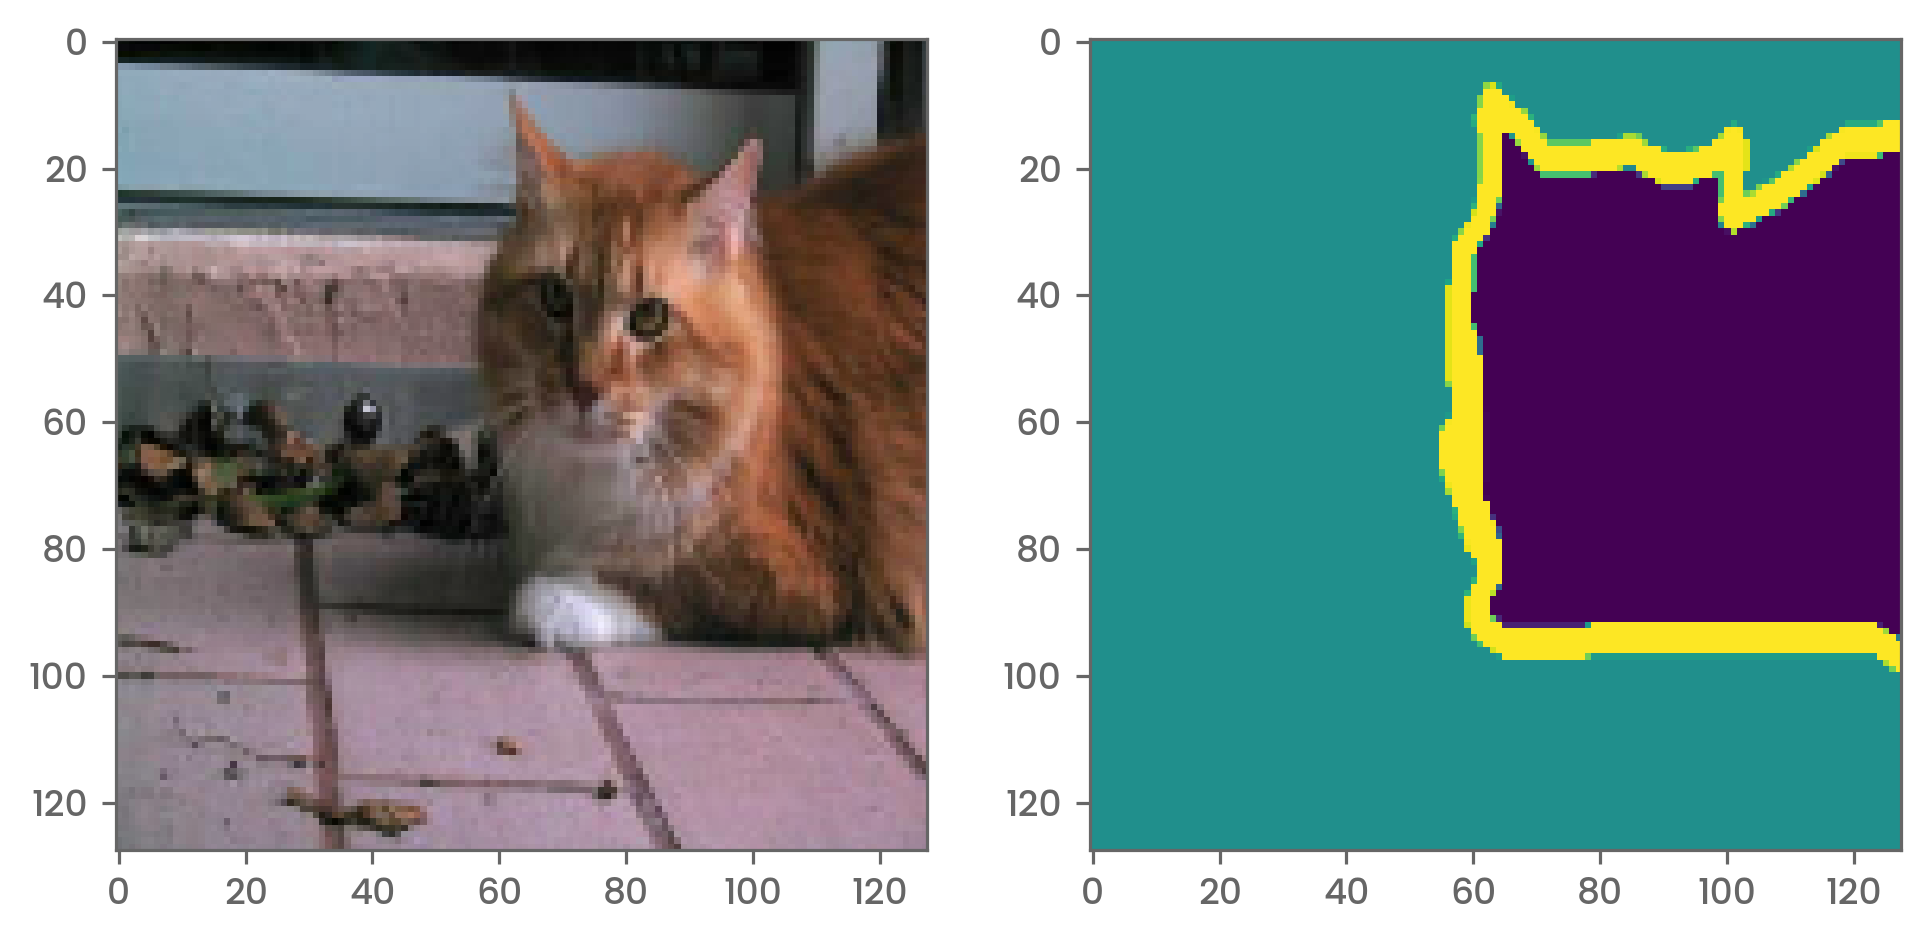

In [12]:
def display_samples(display_list, cols=2, size=(8, 8)):
    rows = (len(display_list) + cols - 1)//cols
    fig, axes = plt.subplots(rows, cols, figsize=size)

    def get_axis(index):
        row, col = index//cols, index%cols
        return axes[row, col] if rows>1 else axes[col]
    
    for index, image in enumerate(display_list):
        axis = get_axis(index)
        axis.imshow(tf.keras.utils.array_to_img(display_list[index]))

for image, mask in test_prep_ds.take(2):
    display_samples([image, mask])

In [139]:
# LEARNING_RATE = 0.001
# N_CLASSES = 3

# layer_id = -1

# def get_layer_id():
#     global layer_id
#     layer_id += 1
    
#     return str(layer_id)
    
# def get_conv_block(filters, strides, padding='same'):
#     return tf.keras.Sequential(
#         [
#             layers.Conv2D(filters, 3, padding=padding, strides=strides),
#             layers.BatchNormalization(),
#             layers.ReLU(),
#         ],
#         name='conv_block_' + get_layer_id()
#     )

# def get_dsc_block(filters, strides, padding='same'):
#     return tf.keras.Sequential(
#         [
#             layers.DepthwiseConv2D(3, padding=padding, strides=strides),
#             layers.BatchNormalization(),
#             layers.ReLU(),
#             layers.Conv2D(filters, 1, padding='valid', strides=1),
#             layers.BatchNormalization(),
#             layers.ReLU(),
#         ],
#         name='dsc_block_' + get_layer_id()
#     )

# def get_conv_transpose_block(filters):
#     initializer = tf.random_normal_initializer(0., 0.02)
#     kwargs = dict(strides=2, padding='same', kernel_initializer=initializer, use_bias=False)
    
#     return tf.keras.Sequential(
#         [
#             layers.Conv2DTranspose(filters, 3, **kwargs),
#             layers.BatchNormalization(),
#             layers.ReLU()
#         ],
#         name='conv_transpose_block_' + get_layer_id()
#     )

# def get_conv_builder(block_type='conv'):
#     if (block_type == 'conv'):
#         return get_conv_block
#     elif (block_type == 'dsc'):
#         return get_dsc_block
#     else:
#         raise ValueError('Invalid block type: ', block_type)

# def upsample(filters, size, norm_type='batchnorm', apply_dropout=False):
#     global upsample_layer_id
#     initializer = tf.random_normal_initializer(0., 0.02)
#     upsample_layer_id += 1
    
#     return tf.keras.Sequential(
#         [
#             layers.Conv2DTranspose(
#                 filters,
#                 size,
#                 strides=2,
#                 padding='same',
#                 kernel_initializer=initializer,
#                 use_bias=False),
#             layers.BatchNormalization(),
#             layers.ReLU()
#         ],
#         name='upsample_block' + str(upsample_layer_id)
#     )

# def create_model(conv_type='conv'):
#     builder = get_conv_builder(conv_type)
#     model = tf.keras.Sequential([
#             tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3)),
#             layers.ZeroPadding2D(1, name='zero_padding'),
#             *(get_conv_block(32, strides=2, padding='valid').layers),
#             builder(64, strides=1),
#             builder(128, strides=2),
#             builder(128, strides=1),
#             builder(256, strides=2),
#             builder(256, strides=1),
#             builder(512, strides=2),
#             builder(512, strides=1),
#             builder(512, strides=1),
#             builder(512, strides=1),
#             builder(512, strides=1),
#             builder(512, strides=1),
#             builder(1024, strides=2),
#             layers.GlobalAveragePooling2D(),
#             layers.Reshape(target_shape=(1, 1, -1)),
#             get_conv_transpose_block(512),
#             get_conv_transpose_block(512),
#             get_conv_transpose_block(512),
#             get_conv_transpose_block(256),
#             get_conv_transpose_block(128),
#             get_conv_transpose_block(64),
#             get_conv_transpose_block(3),
#     ])

#     optimizer = optimizers.Adam(learning_rate=LEARNING_RATE)
#     loss = losses.SparseCategoricalCrossentropy(from_logits=True)
#     model.compile(optimizer=optimizer, loss=loss, metrics='accuracy')

#     return model

# model = create_model(conv_type='dsc')
# model.summary()

Model: "sequential_80"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 zero_padding (ZeroPadding2D  (None, 130, 130, 3)      0         
 )                                                               
                                                                 
 conv2d_574 (Conv2D)         (None, 64, 64, 32)        896       
                                                                 
 batch_normalization_1150 (B  (None, 64, 64, 32)       128       
 atchNormalization)                                              
                                                                 
 re_lu_1150 (ReLU)           (None, 64, 64, 32)        0         
                                                                 
 dsc_block_1 (Sequential)    (None, 64, 64, 64)        2816      
                                                                 
 dsc_block_2 (Sequential)    (None, 32, 32, 128)     

In [169]:
LEARNING_RATE = 0.001
N_CLASSES = 3

layer_id = -1

def get_layer_id():
    global layer_id
    layer_id += 1
    
    return str(layer_id)
    
def get_conv_block(filters, strides, padding='same'):
    return tf.keras.Sequential(
        [
            layers.Conv2D(filters, 3, padding=padding, strides=strides),
            layers.BatchNormalization(),
            layers.ReLU(),
        ],
        name='conv_block_' + get_layer_id()
    )

def get_dsc_block(filters, strides, padding='same'):
    return tf.keras.Sequential(
        [
            layers.DepthwiseConv2D(3, padding=padding, strides=strides),
            layers.BatchNormalization(),
            layers.ReLU(),
            layers.Conv2D(filters, 1, padding='valid', strides=1),
            layers.BatchNormalization(),
            layers.ReLU(),
        ],
        name='dsc_block_' + get_layer_id()
    )

def get_conv_transpose_block(filters):
    initializer = tf.random_normal_initializer(0., 0.02)
    kwargs = dict(strides=2, padding='same', kernel_initializer=initializer, use_bias=False)
    
    return tf.keras.Sequential(
        [
            layers.Conv2DTranspose(filters, 3, **kwargs),
            layers.BatchNormalization(),
            layers.ReLU()
        ],
        name='conv_transpose_block_' + get_layer_id()
    )

def get_conv_builder(block_type='conv'):
    if (block_type == 'conv'):
        return get_conv_block
    elif (block_type == 'dsc'):
        return get_dsc_block
    else:
        raise ValueError('Invalid block type: ', block_type)

def upsample(filters, size, norm_type='batchnorm', apply_dropout=False):
    global upsample_layer_id
    initializer = tf.random_normal_initializer(0., 0.02)
    upsample_layer_id += 1
    
    return tf.keras.Sequential(
        [
            layers.Conv2DTranspose(
                filters,
                size,
                strides=2,
                padding='same',
                kernel_initializer=initializer,
                use_bias=False),
            layers.BatchNormalization(),
            layers.ReLU()
        ],
        name='upsample_block' + str(upsample_layer_id)
    )

def create_model(conv_type='conv'):
    builder = get_conv_builder(conv_type)
    model = tf.keras.Sequential([
            tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3)),
            get_conv_block(32, strides=2),
            builder(64, strides=1),
            # builder(128, strides=2),
            # builder(128, strides=1),
            # builder(256, strides=2),
            # builder(256, strides=1),
            # builder(512, strides=2),
            # builder(512, strides=1),
            # builder(512, strides=1),
            # builder(512, strides=1),
            # builder(512, strides=1),
            # builder(512, strides=1),
            # builder(1024, strides=2),
            # get_conv_transpose_block(512),
            # get_conv_transpose_block(256),
            # get_conv_transpose_block(128),
            # get_conv_transpose_block(64),
            # get_conv_transpose_block(3),
    ])

    optimizer = optimizers.Adam(learning_rate=LEARNING_RATE)
    loss = losses.SparseCategoricalCrossentropy(from_logits=True)
    model.compile(optimizer=optimizer, loss=loss, metrics='accuracy')

    return model

model = create_model()
model.summary()

Model: "sequential_83"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_block_0 (Sequential)   (None, 64, 64, 32)        1024      
                                                                 
 conv_block_1 (Sequential)   (None, 64, 64, 64)        18752     
                                                                 
Total params: 19,776
Trainable params: 19,584
Non-trainable params: 192
_________________________________________________________________


In [153]:
if not Path('weights.h5').exists():
    ! wget "https://www.dropbox.com/s/mo5xrafnei98uuf/oxford_pets_conv_weights.h5?dl=1" -O weights.h5
model.load_weights('weights.h5')

In [189]:
def create_model_for_pruning(m, prunables, info=True):
    pruning_params = {
            'block_size': [1, 16],
            # 'block_pooling_type': 'MAX'
        }
    def apply_pruning_to_layer(l):
        pruning_params = {
            'block_size': (2, 3),
            # 'block_pooling_type': 'MAX'
        }
        cloned_l = None
        if l.__class__.__name__ == 'Conv2D':
            config = l.get_config()
            config['use_bias'] = False
            cloned_l = l.__class__.from_config(config)
            print(config)
            cloned_l.set_weights(l.get_weights()[0])
            print(cloned_l.get_weights())
            cloned_l = tfmot.sparsity.keras.prune_low_magnitude(cloned_l, **pruning_params)
#         print('After: ', l)
        else:
            cloned_l = l.__class__.from_config(l.get_config())
        return cloned_l
        
    def apply_pruning_to_conv_blocks(block):
        clone_block = None
        
        if block.name in prunables:
            # for l in clone_block.layers:
                # print(l.name, list(map(lambda w: w.shape, l.get_weights())))
            # clone_block = tfmot.sparsity.keras.prune_low_magnitude(clone_block, **pruning_params)
#             # layers = list(map(apply_pruning_to_layer, block.layers))
#             # print(layers)
#             # clone_block = tf.keras.Sequential(layers=layers, name=block.name)
# #             clone_block.summary()
            clone_block = models.clone_model(block, clone_function=apply_pruning_to_layer)
        else:
            clone_block = models.clone_model(block)
            clone_block.set_weights(block.get_weights())

        return clone_block
    
    # model_for_pruning = models.clone_model(
    #     m,
    #     clone_function=apply_pruning_to_conv_blocks,
    # )
    pruning_params = {'block_size': [1, 16]}
    model_for_pruning = tfmot.sparsity.keras.prune_low_magnitude(m, **pruning_params)

    optimizer = optimizers.Adam(learning_rate=LEARNING_RATE)
    loss = losses.SparseCategoricalCrossentropy(from_logits=True)
    
    model_for_pruning.compile(
        optimizer=optimizer,
        loss=loss,
        metrics='accuracy'
    )

    return model_for_pruning

# prunable_blocks = list(map(lambda l: l.name, model.layers[1:2]))
prunable_blocks = ['conv_block_1']
model.summary()
model_for_pruning = create_model_for_pruning(model, prunable_blocks)
model_for_pruning.summary()

Model: "sequential_83"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_block_0 (Sequential)   (None, 64, 64, 32)        1024      
                                                                 
 conv_block_1 (Sequential)   (None, 64, 64, 64)        18752     
                                                                 
Total params: 19,776
Trainable params: 19,584
Non-trainable params: 192
_________________________________________________________________


ValueError: Block Sparsity can only be used for layers which have 2-dimensional weights.

In [140]:
# # Pruning start and end blocks
# # prunable_blocks = list(map(lambda l: l.name, model.layers[8:13]))
# prunable_blocks = ['conv2d_79', 'conv2d_80', 'conv2d_81']

# def create_model_for_pruning(m, prunables, info=True):
#     pruning_params = {
#         'pruning_schedule': tfmot.sparsity.keras.ConstantSparsity(.5, 0),
#         'pruning_policy': tfmot.sparsity.keras.PruneForLatencyOnXNNPack()
#     }
#     # def apply_pruning_to_conv_blocks(block):
#     #     clone_block = None
#     #     if block.name == 'zero_padding':
#     #         clone_block = layers.ZeroPadding2D(1, name='zero_padding')
#     #     else:
#     #         clone_block = models.clone_model(block)
#     #         clone_block.set_weights(block.get_weights())
        
#     #     if block.name in prunables:
#     #         clone_block = tfmot.sparsity.keras.prune_low_magnitude(clone_block, **pruning_params)

#     #     return clone_block
    
#     model_for_pruning = tfmot.sparsity.keras.prune_low_magnitude(
#         models.clone_model(m),
#         **pruning_params
#     )

#     optimizer = optimizers.Adam(learning_rate=LEARNING_RATE)
#     loss = losses.SparseCategoricalCrossentropy(from_logits=True)
    
#     model_for_pruning.compile(
#         optimizer=optimizer,
#         loss=loss,
#         metrics='accuracy'
#     )

#     return model_for_pruning

# def summarize_prunable_blocks(m):
#     print('Enabled blocks:', prunable_blocks, 'for pruning')
#     for layer in filter(lambda l: l.name.startswith('dsc_'), m.layers):
#         layer.summary()

# model_for_pruning_8_13 = create_model_for_pruning(model, prunable_blocks)
# summarize_prunable_blocks(model_for_pruning_8_13)
# model_for_pruning_8_13.summary()

/Users/broxoli/miniforge3/lib/python3.9/site-packages/tensorflow_model_optimization/python/core/sparsity/keras/pruning_wrapper.py:212: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  mask = self.add_variable(
/Users/broxoli/miniforge3/lib/python3.9/site-packages/tensorflow_model_optimization/python/core/sparsity/keras/pruning_wrapper.py:219: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  threshold = self.add_variable(
/Users/broxoli/miniforge3/lib/python3.9/site-packages/tensorflow_model_optimization/python/core/sparsity/keras/pruning_wrapper.py:233: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  self.pruning_step = self.add_variable(


Enabled blocks: ['conv2d_79', 'conv2d_80', 'conv2d_81'] for pruning
Model: "dsc_block_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 depthwise_conv2d_332 (Depth  (None, 64, 64, 32)       320       
 wiseConv2D)                                                     
                                                                 
 batch_normalization_1151 (B  (None, 64, 64, 32)       128       
 atchNormalization)                                              
                                                                 
 re_lu_1151 (ReLU)           (None, 64, 64, 32)        0         
                                                                 
 prune_low_magnitude_conv2d_  (None, 64, 64, 64)       4162      
 575 (PruneLowMagnitude)                                         
                                                                 
 batch_normalization_1152 (B  (None, 64, 64, 64)     

In [141]:
print('Enabled blocks:', prunable_blocks, 'for pruning')
for layer in filter(lambda l: l.name.startswith('conv_transpose_block'), model_for_pruning_8_13.layers):
    layer.summary()

Enabled blocks: ['conv2d_79', 'conv2d_80', 'conv2d_81'] for pruning
Model: "conv_transpose_block_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_transpose_249 (Conv2  (None, 2, 2, 512)        4718592   
 DTranspose)                                                     
                                                                 
 batch_normalization_1175 (B  (None, 2, 2, 512)        2048      
 atchNormalization)                                              
                                                                 
 re_lu_1175 (ReLU)           (None, 2, 2, 512)         0         
                                                                 
Total params: 4,720,640
Trainable params: 4,719,616
Non-trainable params: 1,024
_________________________________________________________________
Model: "conv_transpose_block_14"
____________________________________________________________

In [93]:
def train(m, tds, vds, epochs=100, callbacks=[]):
    tds = tds.prefetch(buffer_size=tf.data.AUTOTUNE).take(1)
    vds = vds.prefetch(buffer_size=tf.data.AUTOTUNE).take(1) if vds else None
    history = m.fit(tds, validation_data=vds, epochs=epochs, callbacks=callbacks)

    return history

In [122]:
checkpoint_name_tmpl = 'pruned_model/weights-epoch-{epoch:d}-val_accuracy-{val_accuracy:.4f}.h5'
checkpoint = cbs.ModelCheckpoint(checkpoint_name_tmpl, save_best_only=True, monitor="val_accuracy")
update_pruning = tfmot.sparsity.keras.UpdatePruningStep()

EPOCHS = 1
# EPOCHS = 50
BATCH_SIZE = 16

callbacks = [checkpoint, update_pruning]
tds = train_prep_ds.cache().shuffle(1000, reshuffle_each_iteration=True).batch(BATCH_SIZE)
vds = val_prep_ds.batch(256).cache()

hist_8_13 = train(model_for_pruning_8_13, tds, vds, epochs=EPOCHS, callbacks=callbacks)

with open('pruning.results.pkl', 'wb') as f:
    pickle.dump(hist_8_13.history, f)

model_for_pruning_8_13_acc = model_for_pruning_8_13.evaluate(test_prep_ds.batch(256))
stripped_8_13_model = tfmot.sparsity.keras.strip_pruning(model_for_pruning_8_13)

2022-07-08 15:29:43.453708: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


1/1 [==============================] - ETA: 0s - loss: 1.2062 - accuracy: 0.2983

2022-07-08 15:29:48.848888: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-08 15:29:55.492683: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


1/1 [==============================] - 17s 17s/step - loss: 1.2062 - accuracy: 0.2983 - val_loss: 1.0985 - val_accuracy: 0.5106


2022-07-08 15:29:56.462052: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [123]:
# Save TFLite model to a file
def convert_to_tflite(m, file):
    converter = tf.lite.TFLiteConverter.from_keras_model(m)
    tflite_model = converter.convert()
    with open(file, 'wb') as f:
        f.write(tflite_model)

# Create a compressed copy of input file and return its size
def get_compressed_size_in_kbs(file):
    path = Path(file)
    compressed_file = path.parent / (path.name + '.gz')

    with gzip.open(compressed_file, 'wb') as out:
        with open(file, 'rb') as inp:
            out.write(inp.read())
        
    return compressed_file.stat().st_size/1024.

In [124]:
model_file = 'model.h5'
stripped_8_13_model_file = 'stripped_8_13_model.h5'

model_tflite_file = str(Path(model_file).with_suffix('.tflite'))
stripped_8_13_model_tflite_file = str(Path(stripped_8_13_model_file).with_suffix('.tflite'))

# Save Models
models.save_model(model, model_file, include_optimizer=False)
models.save_model(stripped_8_13_model, stripped_8_13_model_file, include_optimizer=False)

convert_to_tflite(model, model_tflite_file)
convert_to_tflite(stripped_8_13_model, stripped_8_13_model_tflite_file)

2022-07-08 15:30:40.359110: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: /var/folders/8y/5694n0_n42j4fmg6d5j411480000gn/T/tmpf6nmtf37/assets


INFO:tensorflow:Assets written to: /var/folders/8y/5694n0_n42j4fmg6d5j411480000gn/T/tmpf6nmtf37/assets
2022-07-08 15:31:37.408837: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:357] Ignored output_format.
2022-07-08 15:31:37.408879: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:360] Ignored drop_control_dependency.
2022-07-08 15:31:37.415110: I tensorflow/cc/saved_model/reader.cc:43] Reading SavedModel from: /var/folders/8y/5694n0_n42j4fmg6d5j411480000gn/T/tmpf6nmtf37
2022-07-08 15:31:37.437441: I tensorflow/cc/saved_model/reader.cc:78] Reading meta graph with tags { serve }
2022-07-08 15:31:37.437459: I tensorflow/cc/saved_model/reader.cc:119] Reading SavedModel debug info (if present) from: /var/folders/8y/5694n0_n42j4fmg6d5j411480000gn/T/tmpf6nmtf37
2022-07-08 15:31:37.527444: I tensorflow/cc/saved_model/loader.cc:228] Restoring SavedModel bundle.
2022-07-08 15:31:37.847342: I tensorflow/cc/saved_model/loader.cc:212] Running initialization

INFO:tensorflow:Assets written to: /var/folders/8y/5694n0_n42j4fmg6d5j411480000gn/T/tmpbepept06/assets


INFO:tensorflow:Assets written to: /var/folders/8y/5694n0_n42j4fmg6d5j411480000gn/T/tmpbepept06/assets
2022-07-08 15:32:42.157829: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:357] Ignored output_format.
2022-07-08 15:32:42.158350: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:360] Ignored drop_control_dependency.
2022-07-08 15:32:42.159742: I tensorflow/cc/saved_model/reader.cc:43] Reading SavedModel from: /var/folders/8y/5694n0_n42j4fmg6d5j411480000gn/T/tmpbepept06
2022-07-08 15:32:42.190124: I tensorflow/cc/saved_model/reader.cc:78] Reading meta graph with tags { serve }
2022-07-08 15:32:42.190144: I tensorflow/cc/saved_model/reader.cc:119] Reading SavedModel debug info (if present) from: /var/folders/8y/5694n0_n42j4fmg6d5j411480000gn/T/tmpbepept06
2022-07-08 15:32:42.283195: I tensorflow/cc/saved_model/loader.cc:228] Restoring SavedModel bundle.
2022-07-08 15:32:42.617357: I tensorflow/cc/saved_model/loader.cc:212] Running initialization

In [125]:
model_size = get_compressed_size_in_kbs(model_file)
model_tflite_size = get_compressed_size_in_kbs(model_tflite_file)

stripped_8_13_model_size = get_compressed_size_in_kbs(stripped_8_13_model_file)
stripped_8_13_model_tflite_size = get_compressed_size_in_kbs(stripped_8_13_model_tflite_file)

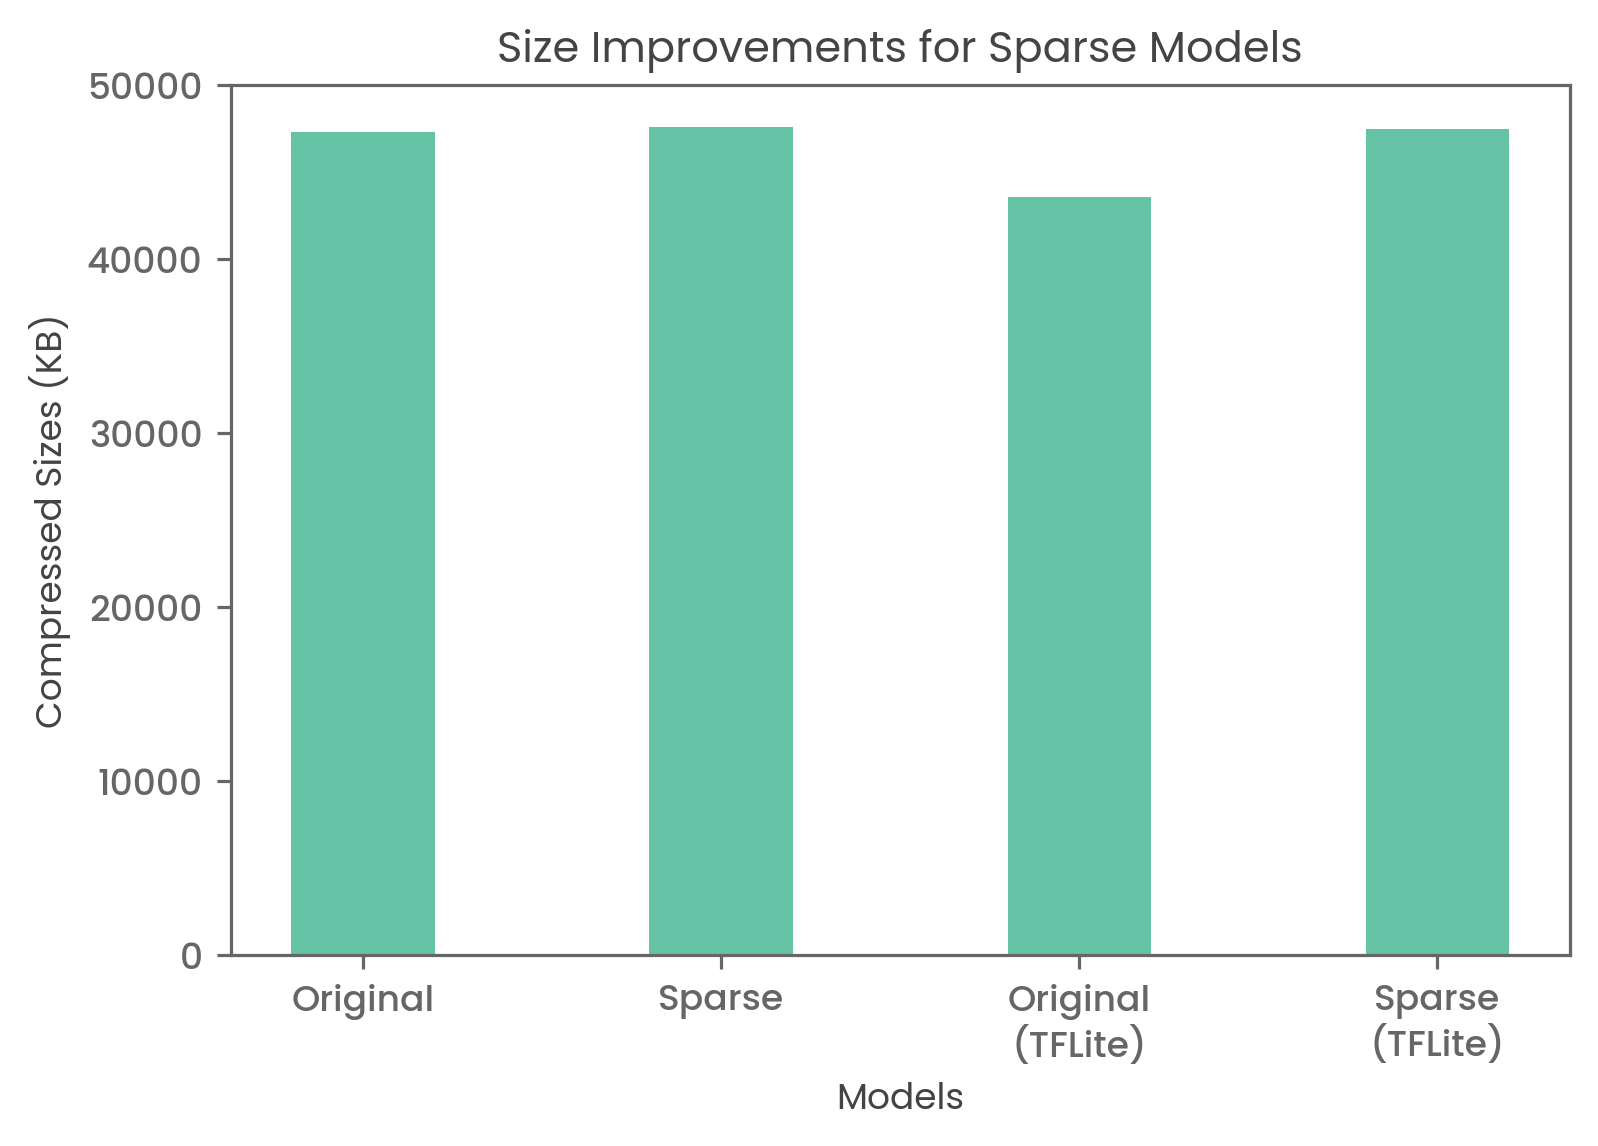

Labels: ['Original', 'Sparse', 'Original\n(TFLite)', 'Sparse\n(TFLite)']
Sizes: [47345.4443359375, 47627.3916015625, 43606.765625, 47517.498046875]


In [126]:
labels = ['Original', 'Sparse', 'Original\n(TFLite)', 'Sparse\n(TFLite)']
sizes = [
         model_size, 
         stripped_8_13_model_size,
         model_tflite_size,
         stripped_8_13_model_tflite_size
    ]
 
plt.bar(labels, sizes, width=0.4)
 
plt.xlabel('Models')
plt.ylabel('Compressed Sizes (KB)')
plt.title('Size Improvements for Sparse Models')
plt.show()

print('Labels:', labels)
print('Sizes:', sizes)

In [ ]:
labels = ['Original', 'Sparse']
accuracies = [0.8540, model_for_pruning_8_13_acc]
 
plt.bar(labels, accuracies, width=0.4)
 
plt.xlabel('Models')
plt.ylabel('Accuracies')
plt.title('Accuracy Comparison with Sparse Models')
plt.show()

print('Labels:', labels)
print('Accuracies:', accuracies)

In [133]:
# stripped_8_13_model.layers[4].layers

In [134]:
import numpy as np

def get_conv_block_sparsity(block):
    # Get block conv layer weights
    conv_weights = block.weights[3].numpy()
    non_zeros = np.count_nonzero(conv_weights)
    total = conv_weights.size
    zeros = total - non_zeros
    sparsity = (zeros/total)*100

    return (sparsity, total)

def display_model_sparsity(m, title='Post-training sparsity'):
    display(ipyw.Label(title))
    for block in filter(lambda l: l.name.startswith('dsc_'), m.layers):
        sparsity, total = get_conv_block_sparsity(block)
        print('Block: {} Sparsity: {}% Total Weights: {}'.format(block.name, sparsity, total))

display_model_sparsity(model, 'Original Model post-training layerwise sparsity.')
display_model_sparsity(stripped_8_13_model, 'Sparse Model post-training layerwise sparsity.')

Label(value='Original Model post-training layerwise sparsity.')

Block: dsc_block_1 Sparsity: 100.0% Total Weights: 32
Block: dsc_block_2 Sparsity: 100.0% Total Weights: 64
Block: dsc_block_3 Sparsity: 100.0% Total Weights: 128
Block: dsc_block_4 Sparsity: 100.0% Total Weights: 128
Block: dsc_block_5 Sparsity: 100.0% Total Weights: 256
Block: dsc_block_6 Sparsity: 100.0% Total Weights: 256
Block: dsc_block_7 Sparsity: 100.0% Total Weights: 512
Block: dsc_block_8 Sparsity: 100.0% Total Weights: 512
Block: dsc_block_9 Sparsity: 100.0% Total Weights: 512
Block: dsc_block_10 Sparsity: 100.0% Total Weights: 512
Block: dsc_block_11 Sparsity: 100.0% Total Weights: 512
Block: dsc_block_12 Sparsity: 100.0% Total Weights: 512


Label(value='Sparse Model post-training layerwise sparsity.')

Block: dsc_block_1 Sparsity: 0.0% Total Weights: 32
Block: dsc_block_2 Sparsity: 0.0% Total Weights: 64
Block: dsc_block_3 Sparsity: 0.0% Total Weights: 128
Block: dsc_block_4 Sparsity: 0.0% Total Weights: 128
Block: dsc_block_5 Sparsity: 0.0% Total Weights: 256
Block: dsc_block_6 Sparsity: 0.0% Total Weights: 256
Block: dsc_block_7 Sparsity: 0.0% Total Weights: 512
Block: dsc_block_8 Sparsity: 0.0% Total Weights: 512
Block: dsc_block_9 Sparsity: 0.0% Total Weights: 512
Block: dsc_block_10 Sparsity: 0.0% Total Weights: 512
Block: dsc_block_11 Sparsity: 0.0% Total Weights: 512
Block: dsc_block_12 Sparsity: 0.0% Total Weights: 512


In [147]:
# Pruning start and end blocks
prunable_blocks = list(map(lambda l: l.name, model.layers[2:13]))
model_for_pruning_2_13 = create_model_for_pruning(model, prunable_blocks)

print('Enabled blocks:', prunable_blocks, 'for pruning')
for layer in model_for_pruning_2_13.layers[2:13]:
    layer.summary()

Enabled blocks: ['conv_block2', 'conv_block3', 'conv_block4', 'conv_block5', 'conv_block6', 'conv_block7', 'conv_block8', 'conv_block9', 'conv_block10', 'conv_block11', 'conv_block12'] for pruning
Model: "conv_block2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 prune_low_magnitude_conv2d_  (None, 32, 32, 128)      147586    
 28 (PruneLowMagnitude)                                          
                                                                 
 prune_low_magnitude_batch_n  (None, 32, 32, 128)      513       
 ormalization_38 (PruneLowMa                                     
 gnitude)                                                        
                                                                 
 prune_low_magnitude_re_lu_3  (None, 32, 32, 128)      1         
 8 (PruneLowMagnitude)                                           
                                                        

In [159]:
checkpoint_name_tmpl = 'pruned_model/weights-epoch-{epoch:d}-val_accuracy-{val_accuracy:.4f}.h5'
checkpoint = cbs.ModelCheckpoint(checkpoint_name_tmpl, save_best_only=True, monitor="val_accuracy")
update_pruning = tfmot.sparsity.keras.UpdatePruningStep()

EPOCHS = 1
# EPOCHS = 50
BATCH_SIZE = 16

callbacks = [checkpoint, update_pruning]
tds = train_prep_ds.cache().shuffle(1000, reshuffle_each_iteration=True).batch(BATCH_SIZE)
vds = val_prep_ds.batch(256).cache()

hist_2_13 = train(model_for_pruning_2_13, tds, vds, epochs=EPOCHS, callbacks=callbacks)

with open('pruning_2_13.results.pkl', 'wb') as f:
    pickle.dump(hist_2_13.history, f)

stripped_2_13_model = tfmot.sparsity.keras.strip_pruning(model_for_pruning_2_13)

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


1/1 [==============================] - ETA: 0s - loss: 0.1723 - accuracy: 0.9232

2022-07-07 10:47:57.325651: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


1/1 [==============================] - 6s 6s/step - loss: 0.1723 - accuracy: 0.9232 - val_loss: 0.1716 - val_accuracy: 0.9244


2022-07-07 10:47:58.243476: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [154]:
stripped_2_13_model_file = 'stripped_2_13_model.h5'
stripped_2_13_model_tflite_file = str(Path(stripped_2_13_model_file).with_suffix('.tflite'))

# Save the model and convert it to TFLite format
models.save_model(stripped_2_13_model, stripped_2_13_model_file, include_optimizer=False)
convert_to_tflite(stripped_2_13_model, stripped_2_13_model_tflite_file)

INFO:tensorflow:Assets written to: /var/folders/8y/5694n0_n42j4fmg6d5j411480000gn/T/tmpy8x59kem/assets


INFO:tensorflow:Assets written to: /var/folders/8y/5694n0_n42j4fmg6d5j411480000gn/T/tmpy8x59kem/assets
2022-07-07 10:38:57.172883: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:357] Ignored output_format.
2022-07-07 10:38:57.172934: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:360] Ignored drop_control_dependency.
2022-07-07 10:38:57.173892: I tensorflow/cc/saved_model/reader.cc:43] Reading SavedModel from: /var/folders/8y/5694n0_n42j4fmg6d5j411480000gn/T/tmpy8x59kem
2022-07-07 10:38:57.187301: I tensorflow/cc/saved_model/reader.cc:78] Reading meta graph with tags { serve }
2022-07-07 10:38:57.187314: I tensorflow/cc/saved_model/reader.cc:119] Reading SavedModel debug info (if present) from: /var/folders/8y/5694n0_n42j4fmg6d5j411480000gn/T/tmpy8x59kem
2022-07-07 10:38:57.241288: I tensorflow/cc/saved_model/loader.cc:228] Restoring SavedModel bundle.
2022-07-07 10:38:57.454323: I tensorflow/cc/saved_model/loader.cc:212] Running initialization

In [155]:
stripped_2_13_model_size = get_compressed_size_in_kbs(stripped_2_13_model_file)
stripped_2_13_model_tflite_size = get_compressed_size_in_kbs(stripped_2_13_model_tflite_file)

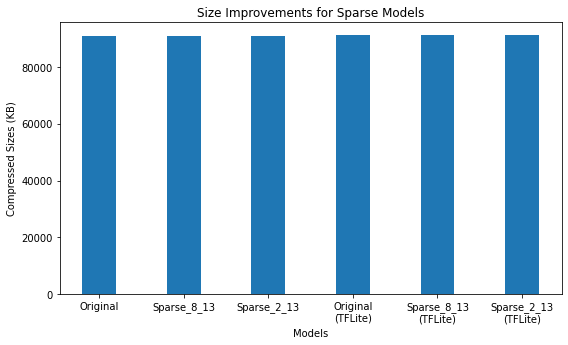

Labels: ['Original', 'Sparse_8_13', 'Sparse_2_13', 'Original\n(TFLite)', 'Sparse_8_13\n(TFLite)', 'Sparse_2_13\n(TFLite)']
Sizes: [91011.6982421875, 91013.1669921875, 91011.9697265625, 91063.193359375, 91062.75, 91062.1123046875]


In [197]:
labels = [
    'Original', 'Sparse_8_13', 'Sparse_2_13',
    'Original\n(TFLite)', 'Sparse_8_13\n(TFLite)', 'Sparse_2_13\n(TFLite)']
sizes = [
    model_size, stripped_model_size, stripped_2_13_model_size,
    model_tflite_size, stripped_model_tflite_size, stripped_2_13_model_tflite_size
]

plt.figure(figsize=(len(labels)*1.5, 5))
plt.bar(labels, sizes, width=0.4)
plt.xlabel('Models')
plt.ylabel('Compressed Sizes (KB)')
plt.title('Size Improvements for Sparse Models')
plt.show()

print('Labels:', labels)
print('Sizes:', sizes)

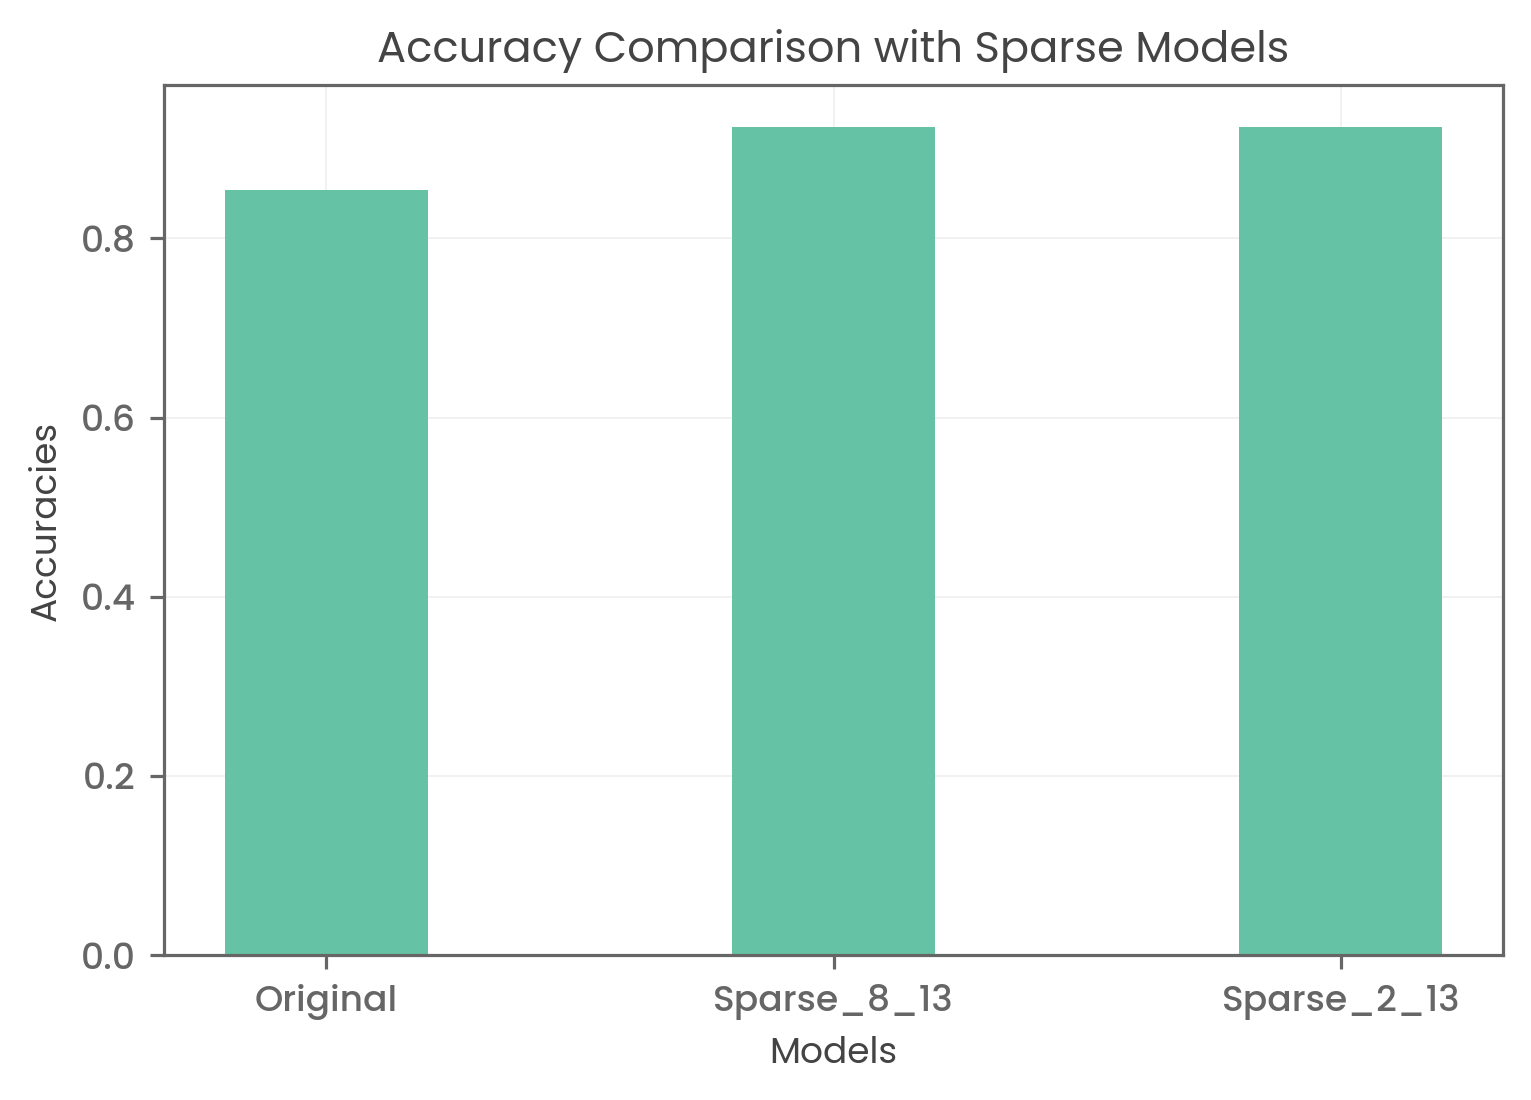

Labels: ['Original', 'Sparse_8_13', 'Sparse_2_13']
Accuracies: [0.854, 0.9244699478149414, 0.9243581295013428]


In [7]:
last_acc = lambda h: h.history['val_accuracy'][-1]
labels = ['Original', 'Sparse_8_13', 'Sparse_2_13']
accuracies = [0.8540, last_acc(hist), last_acc(hist_2_13)]
# accuracies = [0.854, 0.9244699478149414, 0.9243581295013428]
 
plt.bar(labels, accuracies, width=0.4)
 
plt.xlabel('Models')
plt.ylabel('Accuracies')
plt.title('Accuracy Comparison with Sparse Models')
plt.grid(True)
plt.show()

print('Labels:', labels)
print('Accuracies:', accuracies)

In [169]:
display_model_sparsity(stripped_2_13_model,'Sparse_2_13 model post-training layerwise sparsity.')

Label(value='Sparse_2_13 model post-training layerwise sparsity.')

Block: conv_block0 Sparsity: 0.0% Total Weights: 864
Block: conv_block1 Sparsity: 0.0% Total Weights: 18432
Block: conv_block2 Sparsity: 0.0% Total Weights: 73728
Block: conv_block3 Sparsity: 0.0% Total Weights: 147456
Block: conv_block4 Sparsity: 0.0% Total Weights: 294912
Block: conv_block5 Sparsity: 0.0% Total Weights: 589824
Block: conv_block6 Sparsity: 0.0% Total Weights: 1179648
Block: conv_block7 Sparsity: 0.0% Total Weights: 2359296
Block: conv_block8 Sparsity: 0.0% Total Weights: 2359296
Block: conv_block9 Sparsity: 0.0% Total Weights: 2359296
Block: conv_block10 Sparsity: 0.0% Total Weights: 2359296
Block: conv_block11 Sparsity: 0.0% Total Weights: 2359296
Block: conv_block12 Sparsity: 0.0% Total Weights: 4718592
Block: sequential_12 Sparsity: 0.0% Total Weights: 4718592
Block: sequential_13 Sparsity: 0.0% Total Weights: 1179648
Block: sequential_14 Sparsity: 0.0% Total Weights: 294912
Block: sequential_15 Sparsity: 0.0% Total Weights: 73728
Block: sequential_16 Sparsity: 0.0

In [150]:
start_id = 2
end_id = 13
pruning_steps = 5
start_id_fn = lambda x: start_id+x*((end_id-start_id)//pruning_steps)
variable_start_ids = list(reversed(list(map(start_id_fn, range(pruning_steps)))))
variable_start_ids

[10, 8, 6, 4, 2]